In [1]:
!pip install -qU pytorch-lightning wandb --upgrade
!pip install -qU lightning-bolts --upgrade

In [2]:
import os
import torch
import wandb
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

from PIL import Image

from typing import Optional
import torchvision.transforms as transforms

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger, WandbLogger

from pl_bolts.models.self_supervised.resnets import resnet50
from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR
from pl_bolts.metrics import mean, accuracy

from pl_bolts.models.self_supervised.evaluator import Flatten
from pl_bolts.transforms.dataset_normalizations import imagenet_normalization

In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
WANDB = user_secrets.get_secret("wandb")

wandb.login(key=WANDB)

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
class CustomDataset(Dataset):
    def __init__(self, dfx, image_dir,file_ext,transform=None):
        """Create a pytorch dataser

        Parameters
        ----------
        dfx : (DataFrame), DataFrame containing image name and retinopathy grade
        image_dir : (str), path of the image directory
        transform : (Albumentations, optional), Transformations. Defaults to None.
        """
        super().__init__()
        self.dfx = dfx
        self.image_ids = self.dfx.iloc[:,0].values
        self.targets = self.dfx.iloc[:,1].values
        self.num_classes = self.dfx.iloc[:,1].nunique()
        self.image_dir = image_dir
        self.transform = transform
        self.file_ext=file_ext

    def __len__(self):
        return self.image_ids.shape[0]

    def __getitem__(self, idx):
        img_name = self.image_ids[idx]
        index = torch.tensor(self.targets[idx])
        
        img = Image.open(os.path.join(self.image_dir, img_name + self.file_ext)).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, index

In [5]:
class SimCLRTrainDataTransform(object):
    def __init__(
        self,
        input_height: int = 224,
        gaussian_blur: bool = False,
        jitter_strength: float = 1.,
        normalize: Optional[transforms.Normalize] = None
    ) -> None:

        self.jitter_strength = jitter_strength
        self.input_height = input_height
        self.gaussian_blur = gaussian_blur
        self.normalize = normalize

        self.color_jitter = transforms.ColorJitter(
            0.8 * self.jitter_strength,
            0.8 * self.jitter_strength,
            0.8 * self.jitter_strength,
            0.2 * self.jitter_strength
        )

        data_transforms = [
            transforms.RandomResizedCrop(size=self.input_height),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([self.color_jitter], p=0.8),
            transforms.RandomGrayscale(p=0.2)
        ]

        if self.gaussian_blur:
            data_transforms.append(GaussianBlur(kernel_size=int(0.1 * self.input_height, p=0.5)))

        data_transforms.append(transforms.ToTensor())

        if self.normalize:
            data_transforms.append(normalize)

        self.train_transform = transforms.Compose(data_transforms)

    def __call__(self, sample):
        transform = self.train_transform

        xi = transform(sample)
        xj = transform(sample)

        return xi, xj


class SimCLREvalDataTransform(object):
    def __init__(
        self,
        input_height: int = 224,
        normalize: Optional[transforms.Normalize] = None
    ):
        self.input_height = input_height
        self.normalize = normalize

        data_transforms = [
            transforms.Resize((self.input_height,self.input_height)),
            transforms.ToTensor()
        ]

        if self.normalize:
            data_transforms.append(normalize)

        self.test_transform = transforms.Compose(data_transforms)

    def __call__(self, sample):
        transform = self.test_transform

        xi = transform(sample)
        xj = transform(sample)

        return xi, xj


class GaussianBlur(object):
    # Implements Gaussian blur as described in the SimCLR paper
    def __init__(self, kernel_size, p=0.5, min=0.1, max=2.0):
        self.min = min
        self.max = max

        # kernel size is set to be 10% of the image height/width
        self.kernel_size = kernel_size
        self.p = p

    def __call__(self, sample):
        sample = np.array(sample)

        # blur the image with a 50% chance
        prob = np.random.random_sample()

        if prob < self.p:
            sigma = (self.max - self.min) * np.random.random_sample() + self.min
            sample = cv2.GaussianBlur(sample, (self.kernel_size, self.kernel_size), sigma)

        return sample

In [6]:
class DRDataModule(pl.LightningDataModule):

    def __init__(self, df_train, df_valid,
                 train_path, valid_path,
                 train_transforms, val_transforms,
                 num_workers=2,
                 batch_size=32):
        """Pytorch Lightning Data Module

        Parameters
        ----------
        df_train : (DataFrame), Train dataframe
        df_valid : (DataFrame), Val dataframe
        df_test  : (DataFrame), Test dataframe
        train_path : (str), Train path
        valid_path : (str), Val path
        test_path : (str), Test path
        train_transforms : (Albumentation), Train transformations
        val_transforms : (Albumentation), Val transformations
        test_transforms : (Albumentation), Test transformations
        num_workers : (int, optional), Num workers. Defaults to 2.
        batch_size : (int, optional), Batch Size. Defaults to 32.
        """
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_data = CustomDataset(df_train,
                                        train_path,
                                        '.png',
                                        transform=train_transforms)
        
        self.val_data = CustomDataset(df_valid,
                                      valid_path,
                                      '.jpg',
                                      transform=val_transforms)

    def train_dataloader(self):
        return DataLoader(self.train_data,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_data,
                          batch_size=self.batch_size,
                          shuffle=False,
                          num_workers=self.num_workers)

# Create DM

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split


PATH = '../input/indian-retina-classification/B._20Disease_20Grading/B. Disease Grading/'
IMG_PATH='../input/indian-retina-classification/B._20Disease_20Grading/B. Disease Grading/1. Original Images/'
IMG_PATH_1 = '../input/aptos/train_images_resize'
dfx = pd.read_csv('../input/aptos/train.csv')
df_test = pd.read_csv('../input/indian-retina-classification/B._20Disease_20Grading/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv',usecols = ['Image name','Retinopathy grade'])

# df_train = df_train.reset_index(drop=True)
# df_valid = df_valid.reset_index(drop=True)

dm = DRDataModule(dfx, df_test,
                  IMG_PATH_1,
                  IMG_PATH+'images_resized',
                  SimCLRTrainDataTransform(normalize=transforms.Normalize((0.4602, 0.2465, 0.0801),
                                                                          (0.2492, 0.1385, 0.0807))),
                  SimCLREvalDataTransform(normalize=transforms.Normalize((0.4602, 0.2465, 0.0801),
                                                                          (0.2492, 0.1385, 0.0807))),
                  num_workers=2,
                  batch_size=32)

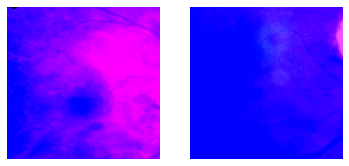

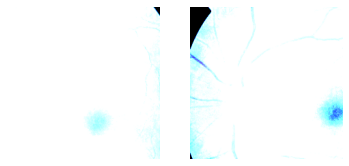

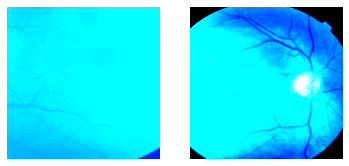

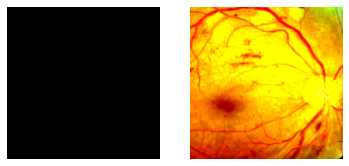

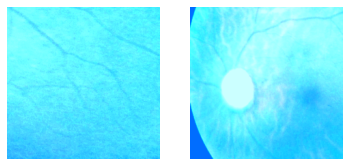

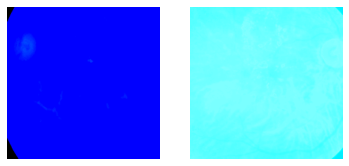

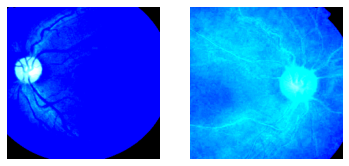

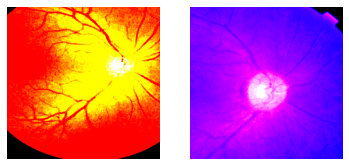

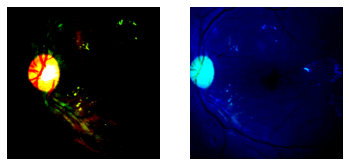

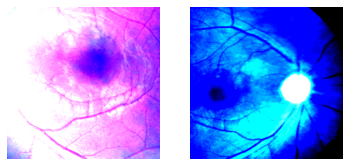

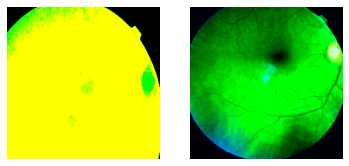

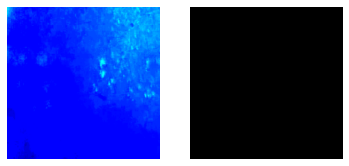

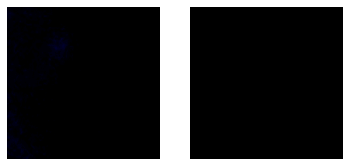

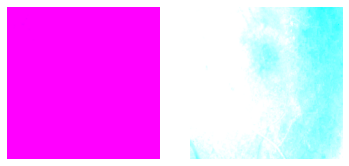

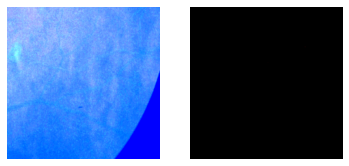

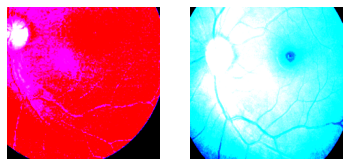

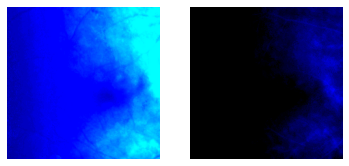

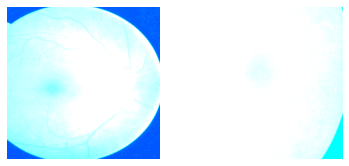

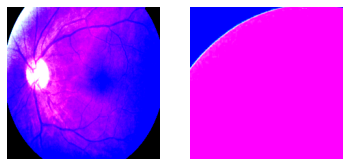

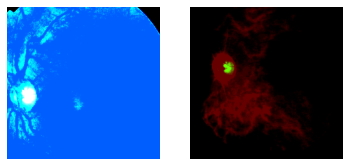

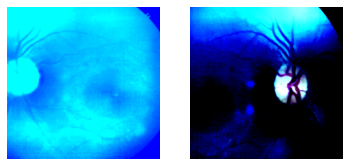

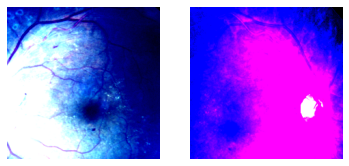

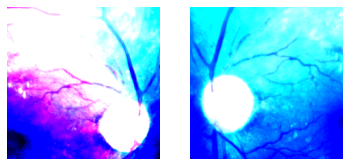

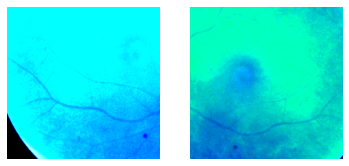

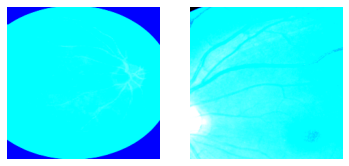

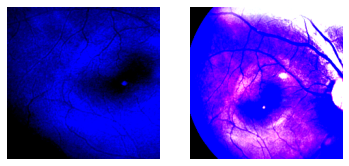

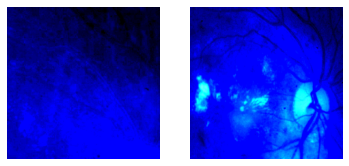

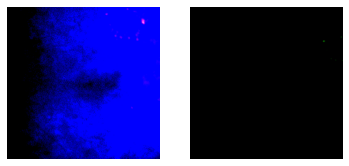

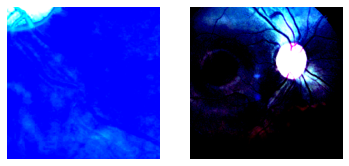

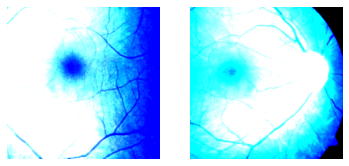

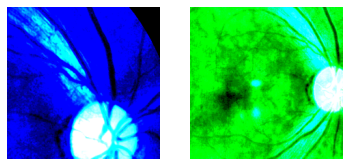

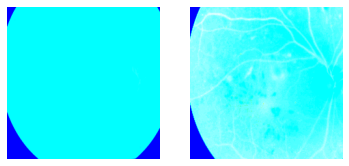

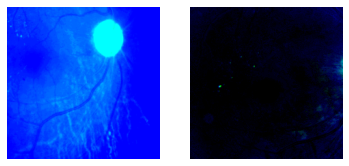

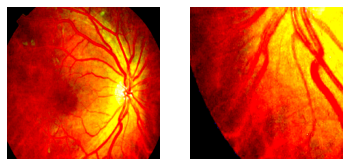

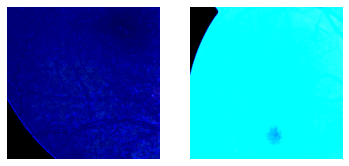

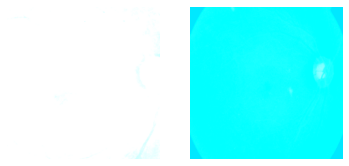

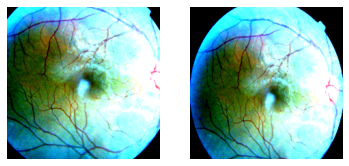

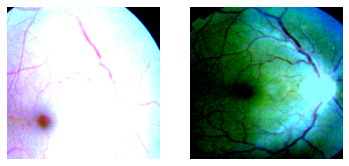

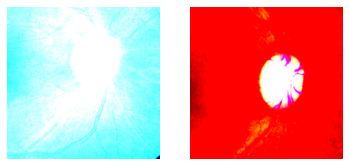

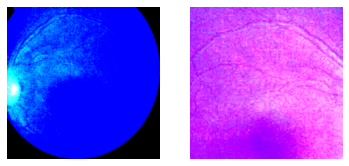

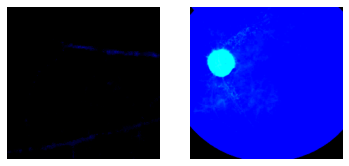

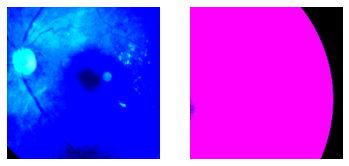

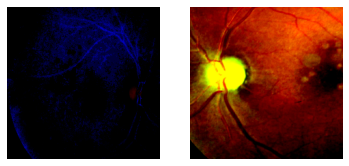

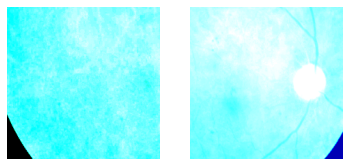

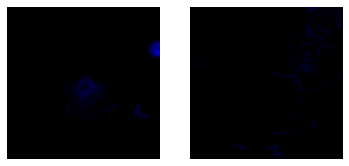

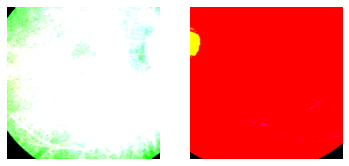

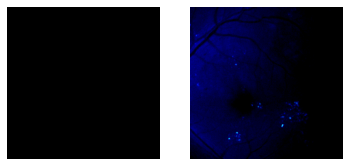

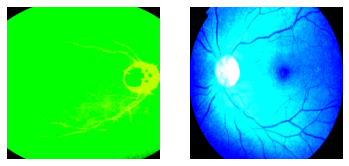

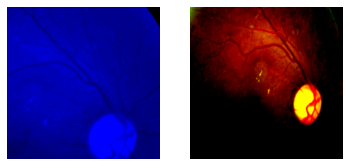

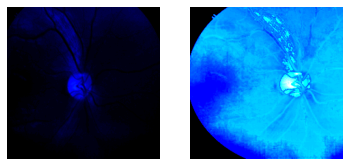

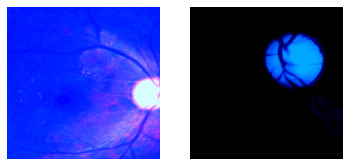

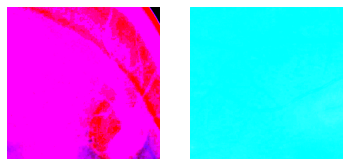

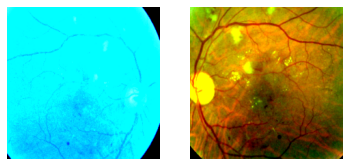

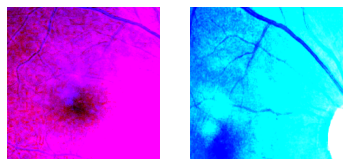

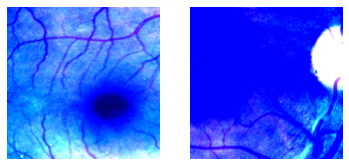

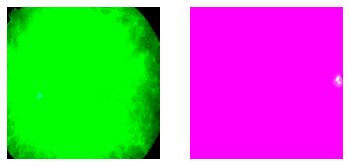

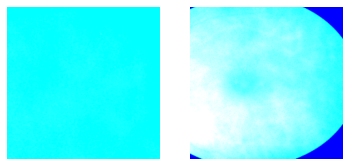

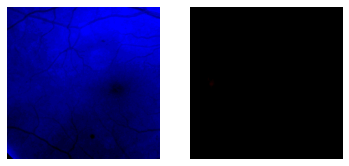

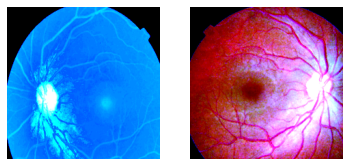

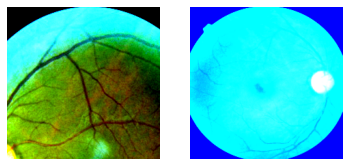

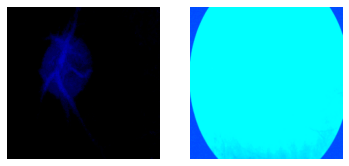

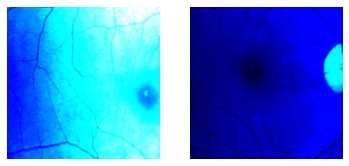

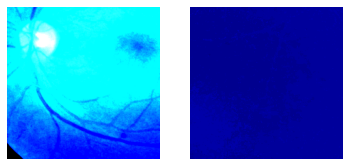

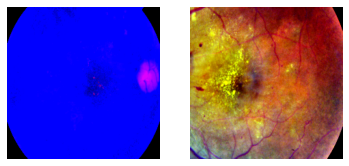

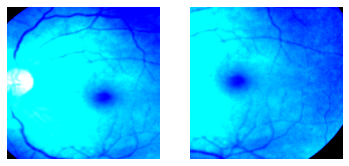

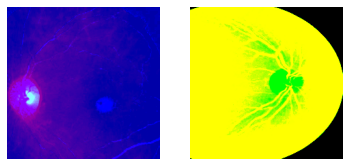

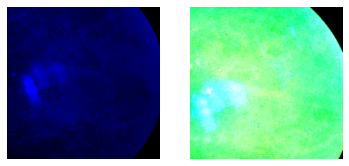

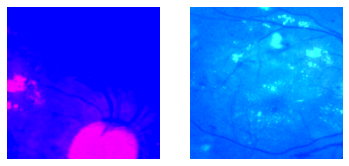

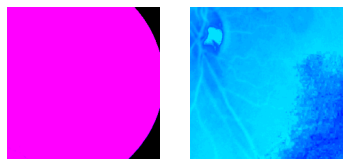

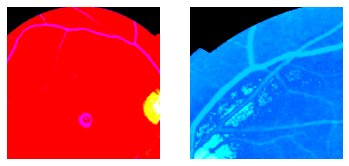

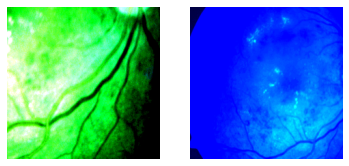

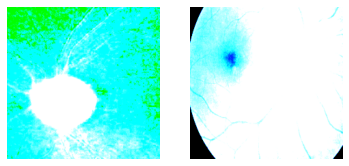

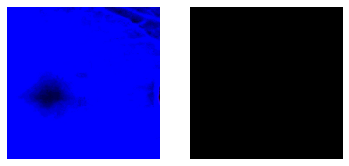

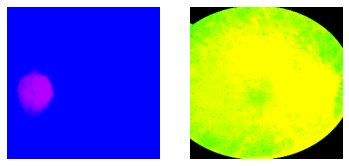

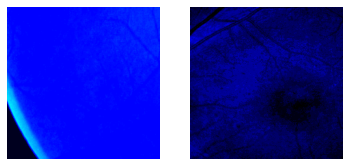

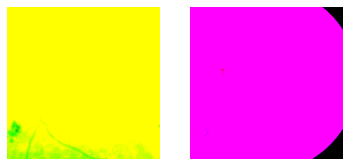

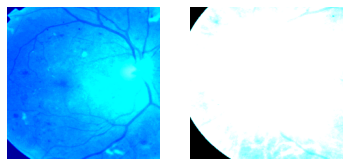

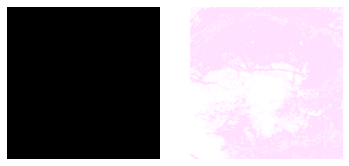

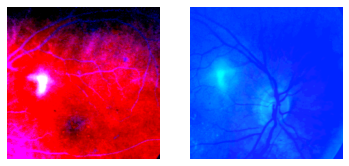

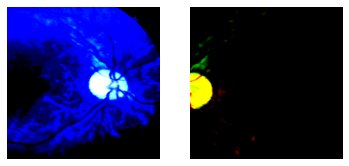

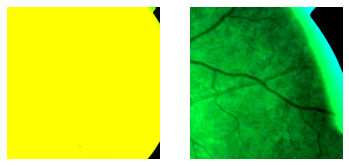

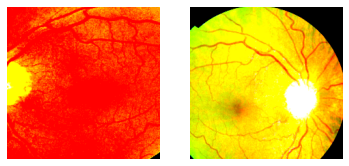

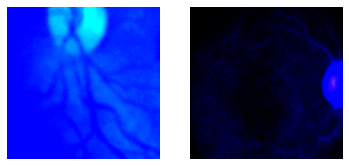

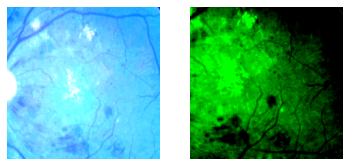

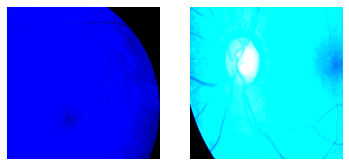

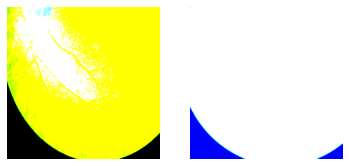

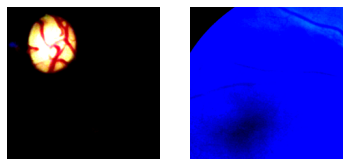

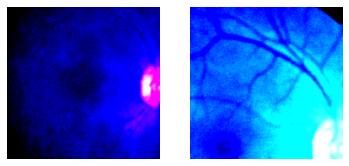

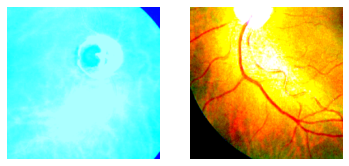

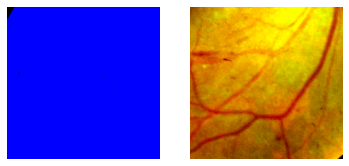

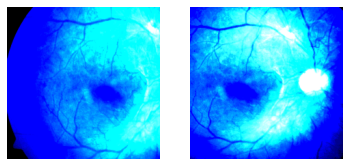

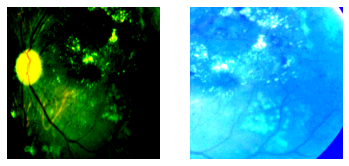

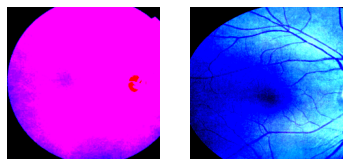

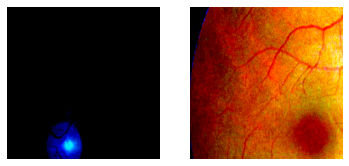

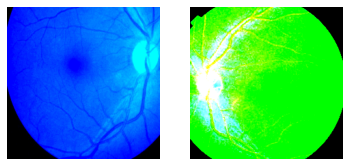

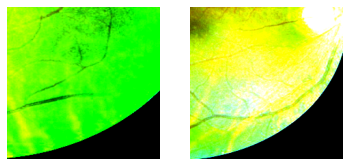

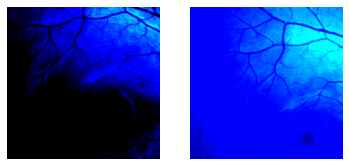

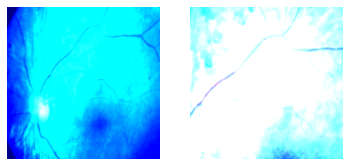

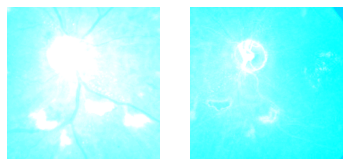

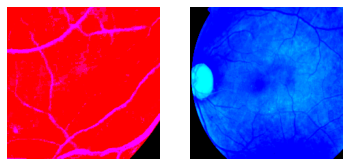

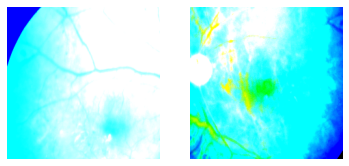

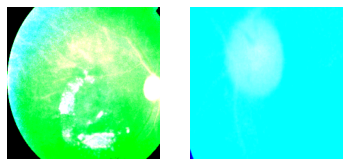

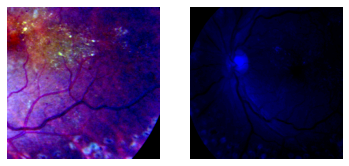

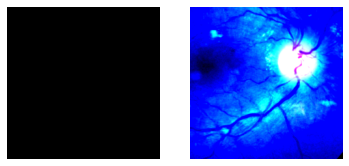

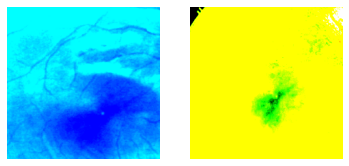

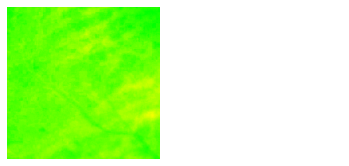

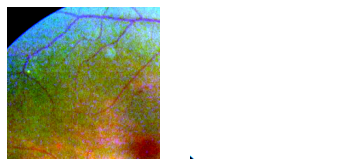

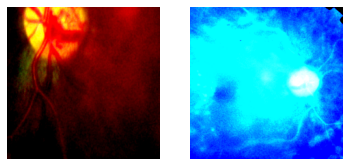

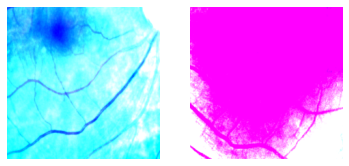

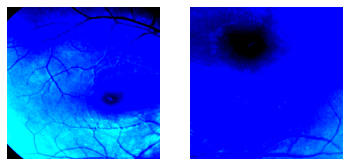

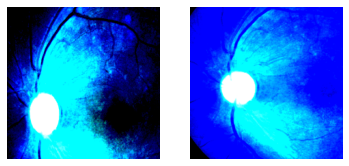

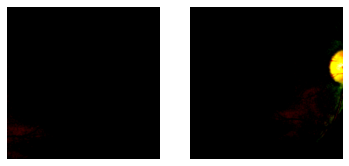

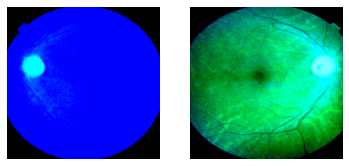

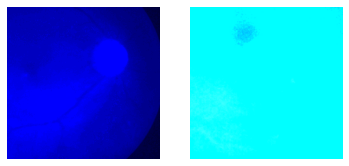

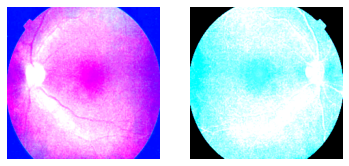

In [8]:
for (img1,img2),_ in dm.train_dataloader():
    for i1,i2 in zip(img1,img2):
        plt.subplot(1,2,1)
        plt.imshow(i1.permute(1,2,0))
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(i2.permute(1,2,0))
        plt.axis('off')
        plt.show()
        break
    break

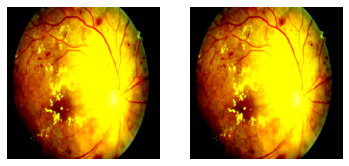

In [9]:
for (img1,img2),_ in dm.val_dataloader():
    for i1,i2 in zip(img1,img2):
        plt.subplot(1,2,1)
        plt.imshow(i1.permute(1,2,0))
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(i2.permute(1,2,0))
        plt.axis('off')
        plt.show()
        break
    break

In [10]:
def nt_xent_loss(out_1, out_2, temperature):
    out = torch.cat([out_1, out_2], dim=0)
    n_samples = len(out)

    # Full similarity matrix
    cov = torch.mm(out, out.t().contiguous())
    sim = torch.exp(cov / temperature)

    mask = ~torch.eye(n_samples, device=sim.device).bool()
    neg = sim.masked_select(mask).view(n_samples, -1).sum(dim=-1)

    # Positive similarity
    pos = torch.exp(torch.sum(out_1 * out_2, dim=-1) / temperature)
    pos = torch.cat([pos, pos], dim=0)

    loss = -torch.log(pos / neg).mean()
    return loss

In [11]:
class Projection(nn.Module):
    def __init__(self, input_dim=2048, hidden_dim=2048, output_dim=128):
        super().__init__()
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.model = nn.Sequential(
#             nn.AdaptiveAvgPool2d((1, 1)),
#             Flatten(),
            nn.Linear(self.input_dim, self.hidden_dim, bias=True),
            nn.BatchNorm1d(self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.output_dim, bias=False))

    def forward(self, x):
        x = self.model(x)
        return F.normalize(x, dim=1)

In [12]:
class SimCLR(pl.LightningModule):
    def __init__(self,
                 batch_size,
                 num_samples,
                 warmup_epochs=10,
                 lr=1e-4,
                 opt_weight_decay=1e-6,
                 loss_temperature=0.5,
                 **kwargs):
        """
        Args:
            batch_size: the batch size
            num_samples: num samples in the dataset
            warmup_epochs: epochs to warmup the lr for
            lr: the optimizer learning rate
            opt_weight_decay: the optimizer weight decay
            loss_temperature: the loss temperature
        """
        super().__init__()
        self.save_hyperparameters()

        self.nt_xent_loss = nt_xent_loss
        self.encoder = self.init_encoder()

        # h -> || -> z
        self.projection = Projection()

    def init_encoder(self):
        encoder = resnet50(return_all_feature_maps=False)
        return encoder

    def exclude_from_wt_decay(self, named_params, weight_decay, skip_list=['bias', 'bn']):
        params = []
        excluded_params = []

        for name, param in named_params:
            if not param.requires_grad:
                continue
            elif any(layer_name in name for layer_name in skip_list):
                excluded_params.append(param)
            else:
                params.append(param)

        return [
            {'params': params, 'weight_decay': weight_decay},
            {'params': excluded_params, 'weight_decay': 0.}
        ]

    def setup(self, stage):
        global_batch_size = self.trainer.world_size * self.hparams.batch_size
        self.train_iters_per_epoch = self.hparams.num_samples // global_batch_size

    def configure_optimizers(self):
        # TRICK 1 (Use lars + filter weights)
        # exclude certain parameters
        parameters = self.exclude_from_wt_decay(
            self.named_parameters(),
            weight_decay=self.hparams.opt_weight_decay
        )

        optimizer = Adam(parameters, lr=self.hparams.lr)

        # Trick 2 (after each step)
        self.hparams.warmup_epochs = self.hparams.warmup_epochs * self.train_iters_per_epoch
        max_epochs = self.trainer.max_epochs * self.train_iters_per_epoch

        linear_warmup_cosine_decay = LinearWarmupCosineAnnealingLR(
            optimizer,
            warmup_epochs=self.hparams.warmup_epochs,
            max_epochs=max_epochs,
            warmup_start_lr=0,
            eta_min=0
        )

        scheduler = {
            'scheduler': linear_warmup_cosine_decay,
            'interval': 'step',
            'frequency': 1
        }

        return [optimizer], [scheduler]

    def forward(self, x):
        if isinstance(x, list):
            x = x[0]

        result = self.encoder(x)
        if isinstance(result, list):
            result = result[-1]
        return result

    def training_step(self, batch, batch_idx):
        loss = self.shared_step(batch, batch_idx)

        self.log('train_loss', loss,  prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.shared_step(batch, batch_idx)

        self.log('avg_val_loss', loss,  prog_bar=True, on_epoch=True)
        return loss

    def shared_step(self, batch, batch_idx):
        (img1, img2), y = batch

        # ENCODE
        # encode -> representations
        # (b, 3, 32, 32) -> (b, 2048, 2, 2)
        h1 = self.encoder(img1)
        h2 = self.encoder(img2)

        # the bolts resnets return a list of feature maps
        if isinstance(h1, list):
            h1 = h1[-1]
            h2 = h2[-1]

        # PROJECT
        # img -> E -> h -> || -> z
        # (b, 2048, 2, 2) -> (b, 128)
        z1 = self.projection(h1)
        z2 = self.projection(h2)

        loss = self.nt_xent_loss(z1, z2, self.hparams.loss_temperature)

        return loss

In [13]:
from pl_bolts.models.self_supervised.evaluator import SSLEvaluator
from torchmetrics import Accuracy

class SSLOnlineEvaluator(pl.Callback):
    def __init__(self,drop_p=0.2,hidden_dim=1024,z_dim=2048,num_classes=5):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.drop_p = drop_p
        self.optimizer = None
        self.z_dim = z_dim
        self.num_classes = num_classes
        self.accuracy = Accuracy()
        
    def on_pretrain_routine_start(self, trainer, pl_module):
        
        pl_module.non_linear_eval = SSLEvaluator(
            n_input = self.z_dim,
            n_classes = self.num_classes,
            p = self.drop_p
        ).to(pl_module.device)
        
        self.optimizer = torch.optim.SGD(pl_module.non_linear_eval.parameters(), lr=1e-3)
        
    def on_train_batch_end(
        self,
        trainer,
        pl_module,
        outputs,
        batch,
        batch_idx,
        dataloader_idx,
    ) -> None:
        (x,_),y = batch
        x = x.to(pl_module.device)
        y = y.to(pl_module.device)
        
        with torch.no_grad():
            rep = pl_module(x)
        
        preds = pl_module.non_linear_eval(rep)
        loss = F.cross_entropy(preds,y)
        
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        
        acc = self.accuracy(preds.to('cpu'),y.to('cpu'))
        self.log('ssl_train_loss', loss, prog_bar=True, on_epoch=True)
        self.log('ssl_train_acc', acc, prog_bar=True, on_epoch=True)
        
    def on_validation_batch_end(
        self,
        trainer,
        pl_module,
        outputs,
        batch,
        batch_idx,
        dataloader_idx,
    ) -> None:
        (x,_),y = batch
        x = x.to(pl_module.device)
        y = y.to(pl_module.device)
        
        with torch.no_grad():
            rep = pl_module(x)
        
        preds = pl_module.non_linear_eval(rep)
        loss = F.cross_entropy(preds,y)
        
        acc = self.accuracy(preds.to('cpu'),y.to('cpu'))
        self.log('ssl_val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('ssl_val_acc', acc, prog_bar=True, on_epoch=True)

In [14]:
online_finetuner = SSLOnlineEvaluator(z_dim=2048, num_classes=5)

checkpoint_callback = ModelCheckpoint(monitor='ssl_train_acc',
                                          save_top_k=1,
                                          save_last=True,
                                          save_weights_only=True,
                                          filename='simCLR',
                                          verbose=True,
                                          mode='max')

lr_logger = LearningRateMonitor()

wandb_logger = WandbLogger(project='simclr', log_model=False)

callbacks = [online_finetuner, lr_logger, checkpoint_callback]

logger = [wandb_logger]

In [15]:
batch_size = 32

train_samples = len(dfx)

model = SimCLR(batch_size=batch_size, num_samples=train_samples)
trainer = pl.Trainer(callbacks=callbacks, logger=logger, gpus=-1, max_epochs=100)

wandb_logger.watch(model)
trainer.fit(model, dm)

wandb: Currently logged in as: dineswar_alt (use `wandb login --relogin` to force relogin)


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:292: LightningDeprecationWarning: Base `Callback.on_train_batch_end` hook signature has changed in v1.5. The `dataloader_idx` argument will be removed in v1.7.
  f"Base `Callback.{hook}` hook signature has changed in v1.5."


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
wandb.finish()